# 5. Optimizing, and sampling the kernel in OJ 287
## I. Introduction to pymc3, xo, and gradients


Adapted from [a notebook provided by Dan Foreman-Mackey](https://gist.github.com/dfm/f84d0ee1af2425fc29efefe29a7e934d).


In [1]:
%matplotlib inline

In [2]:
%config InlineBackend.figure_format = "retina"

import matplotlib.pyplot as plt
plt.style.use("default")
plt.rcParams["savefig.dpi"] = 100
plt.rcParams["figure.dpi"] = 100
plt.rcParams["font.size"] = 16
plt.rcParams["font.family"] = "sans-serif"
plt.rcParams["font.sans-serif"] = ["Liberation Sans"]
plt.rcParams["mathtext.fontset"] = "custom"

import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

In [3]:
import os
import lightkurve as lk

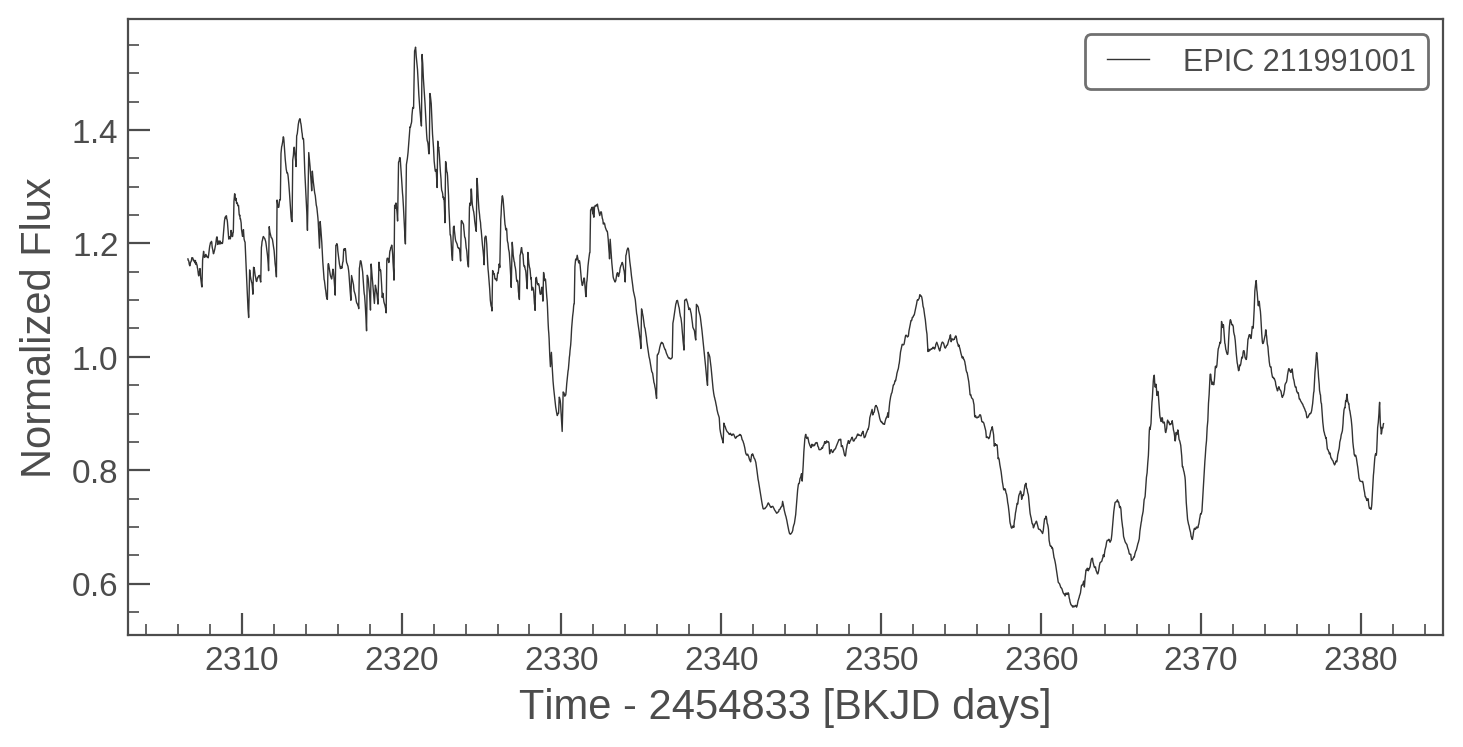

In [4]:
# MAST appears to have gone down, but I downloaded it once before it died
# so I'll used the cached file
epicid = 211991001
# lcf = lk.search_lightcurvefile("EPIC {0}".format(epicid), campaign=5)[0].download()
lcf = lk.KeplerLightCurveFile(os.path.expanduser(
    "~/.lightkurve-cache/mastDownload/K2/ktwo211991001-c05_lc/ktwo211991001-c05_llc.fits"))
lc = lcf.PDCSAP_FLUX.remove_nans().normalize().remove_outliers()
lc.plot();

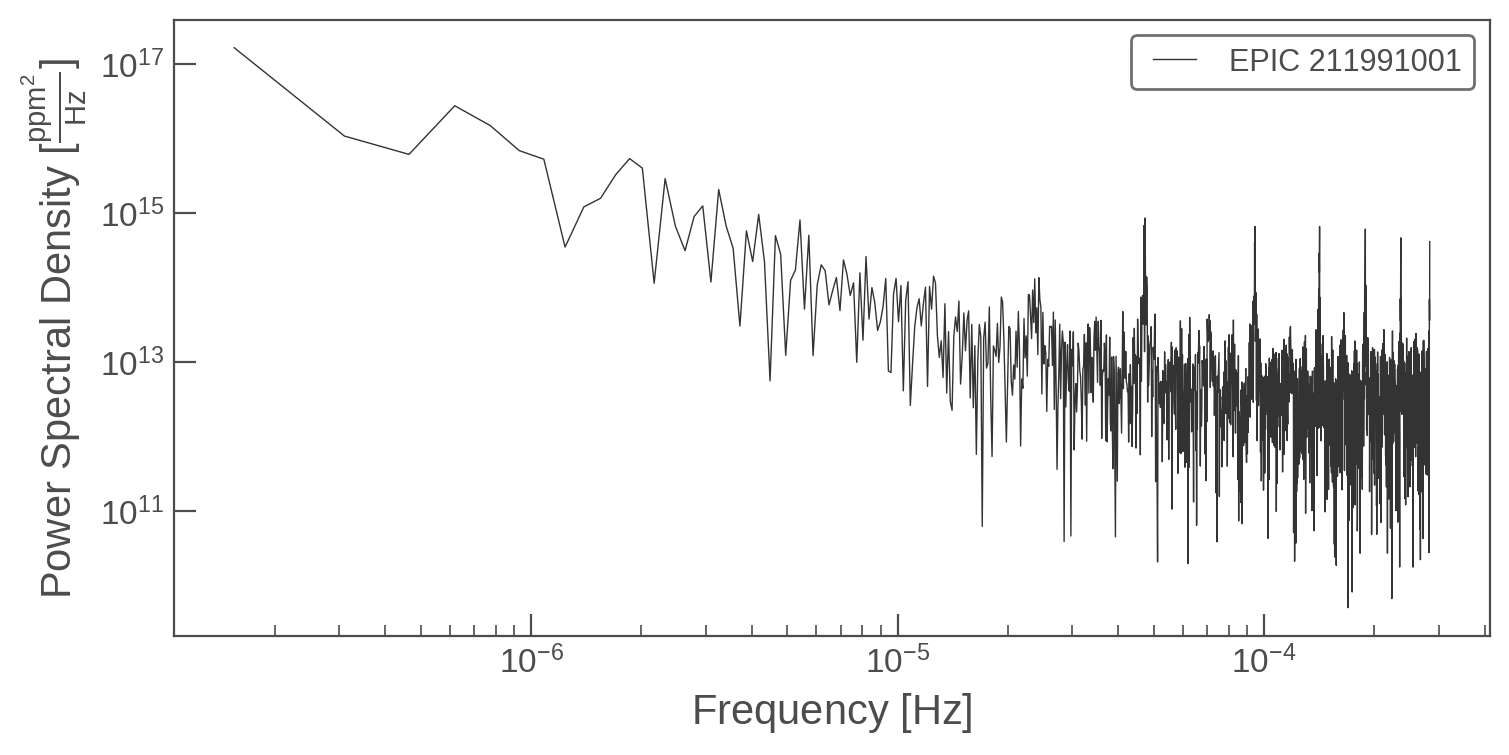

In [5]:
import astropy.units as u
pg = lc.to_periodogram(normalization="psd", freq_unit=u.Hz)
pg.plot()
plt.yscale("log")
plt.xscale("log");

In [6]:
import numpy as np
import pymc3 as pm
import theano.tensor as tt

import exoplanet as xo

In [7]:
# Make sure that all the data have the right type
x = np.ascontiguousarray(lc.time, dtype=np.float64)
y = np.ascontiguousarray(lc.flux - 1, dtype=np.float64)
yerr = np.ascontiguousarray(lc.flux_err, dtype=np.float64)

# Build the model in PyMC3
with pm.Model() as gp_model:
    
    # The mean stellar flux (relative to the normalized baseline) in ppm
    mean = pm.Normal("mean", mu=0, sd=np.std(y))
    
    # A jitter term to capture underestimated error bars and model misspecification
    logs2 = pm.Normal("logs2", mu=np.log(np.mean(yerr**2)), sd=10.0)
    
    # Two SHO terms with two parameters each:
    # 1. The amplitude of the variability, and
    # 2. The turnover (angular) frequency in 1/d
    logw_init = np.log(2*np.pi) - np.log([5, 10])
    loga = pm.Normal("loga", mu=np.log(np.var(y)), sd=10.0, shape=2)
    logw0 = pm.Normal("logw0", mu=logw_init, sd=10.0, shape=2)
    logS0 = pm.Deterministic("logS0", loga-logw0+0.5*np.log(2))
    
    kernel = xo.gp.terms.SHOTerm(log_S0=logS0[0], log_w0=logw0[0], Q=1/np.sqrt(2))
    kernel += xo.gp.terms.SHOTerm(log_S0=logS0[1], log_w0=logw0[1], Q=1/np.sqrt(2))
    
    # We put this together and evaluate the GP likelihood
    gp = xo.gp.GP(kernel, x, yerr**2 + tt.exp(logs2))
    pm.Potential("loglike", gp.log_likelihood(y - mean))
    
    # Then we maximize the log posterior to find an estimate of the maximum
    # a posteriori (map) parameters. Note: The order of these optimizations
    # has been chosen to work for this problem using a combination of intution
    # and trial and error.
    gp_map_soln = gp_model.test_point
    gp_map_soln = xo.optimize(gp_map_soln, vars=[mean])
    gp_map_soln = xo.optimize(gp_map_soln, vars=[logs2])
    gp_map_soln = xo.optimize(gp_map_soln, vars=[loga, logw0])
    gp_map_soln = xo.optimize(gp_map_soln)

optimizing logp for variables: ['mean']
message: Optimization terminated successfully.
logp: -24322.20447763328 -> -24322.201942705386
optimizing logp for variables: ['logs2']
message: Optimization terminated successfully.
logp: -24322.201942705386 -> 10108.01804591798
optimizing logp for variables: ['logw0', 'loga']
message: Optimization terminated successfully.
logp: 10108.01804591798 -> 10884.121710663849
optimizing logp for variables: ['logw0', 'loga', 'logs2', 'mean']
message: Desired error not necessarily achieved due to precision loss.
logp: 10884.121710663849 -> 12192.914389108528


In [8]:
with gp_model:
    K = xo.eval_in_model(gp.kernel.value(x[None, :] - x[:, None]), gp_map_soln)

In [9]:
sim = np.random.multivariate_normal(
    np.zeros_like(y)+gp_map_soln["mean"], K, size=50)

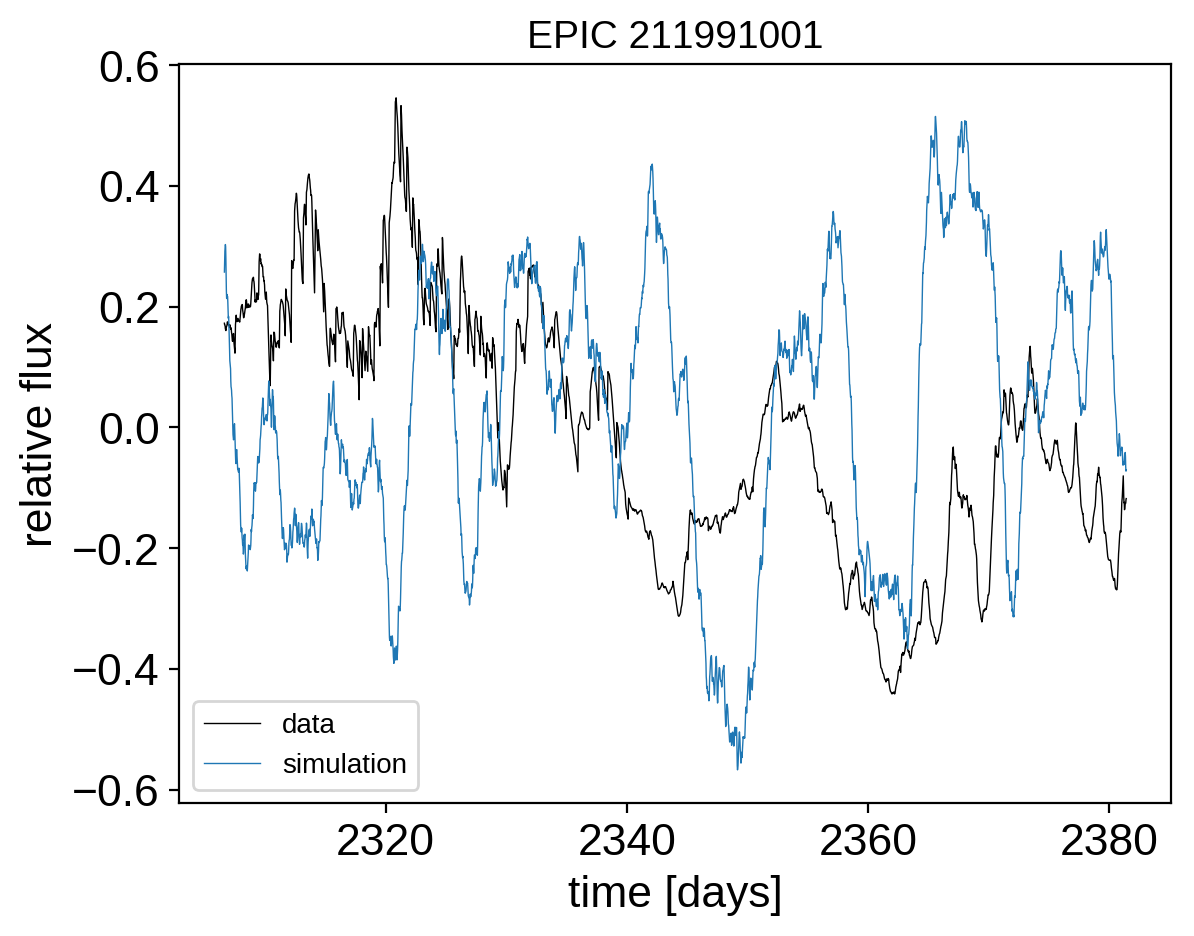

In [10]:
plt.plot(x, y, "k", lw=0.5, label="data")
plt.plot(x, sim[0], lw=0.5, label="simulation")
plt.ylabel("relative flux")
plt.xlabel("time [days]")
plt.title("EPIC {0}".format(epicid), fontsize=14)
plt.legend(fontsize=10);